# Exploratory Data Analysis of Pi Hole DNS Request Logs

Dataset is sourced from the event based logging of Pi Hole. Data is stored in a SQLite database with a timestamp, client requestor, whether it was blocked, and the domain name.

## Objectives

 - Identify methods for data ingestion/cleansing/preparation.
 - Find statistical relationships that can be used to handrail online learning
 - Look at potential imablances between domain names (overrepresentation)



In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import blackmanharris

# Load Dataset from SQLite DB

In [1467]:
"""
Load Pi Hole logging data from SQLite database using sqlalchemy and pandas.
"""

db_connect = create_engine('sqlite:///pihole-FTL.db')
connection = db_connect.raw_connection()
df = pd.read_sql("SELECT * FROM queries", con=connection)
df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)
df['not_blocked'] = df.status.apply(lambda x: 1 if x in [2,3] else 0)

# Apply some data prep to timestamps

In [467]:
"""
Apply transformations to timestamps for aggregation
Operations performed:
    Get timestamps relative to initial timestamp
    Bin data into 100 sec (~1.7 min) bins
    Modulo 86400 for seconds elapsed
    Div 86400 for days elapsed
Initial day in dataset is roughly at midnight, so no 
offset in time required or pruning of dataset.
"""

agg_df = df.copy()
agg_df['timestamp'] = agg_df.timestamp.round(-2)
agg_df['timestamp'] -= agg_df.timestamp.min()
agg_df['not_blocked'] = agg_df.blocked.apply(lambda x: 1 if not x else 0)
agg_df['day'] = agg_df.timestamp.apply(lambda x: int(x / (60*60*24)))
agg_df['time_of_day'] = agg_df.timestamp.apply(lambda x: x % (60*60*24))

In [571]:
"""
Find number of unique subdomains and domains.
"""

print('Unique domains: ',df.domain.nunique())
print('Unique sub domains: ',len(np.concatenate(np.unique(df.domain.apply(lambda x: x.split('.')).values))))

Unique domains:  11527
Unique sub domains:  38424


[442518 128867]


Text(0, 0.5, '# of DNS Requests')

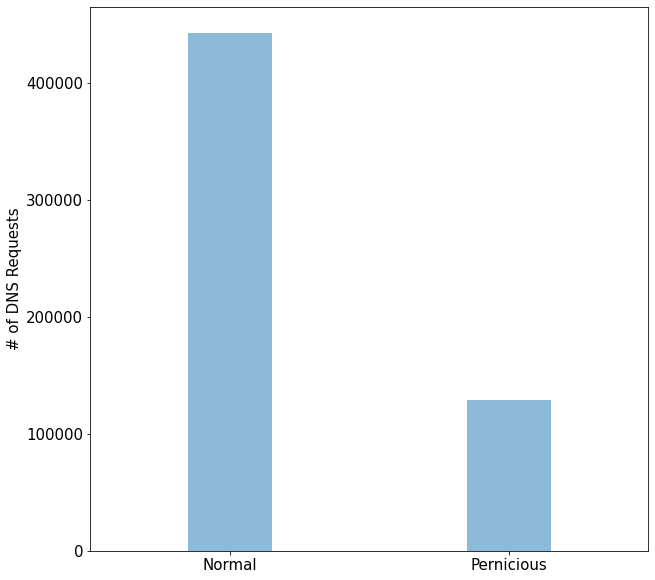

In [1013]:
labels, counts = np.unique(df.blocked.values, return_counts=True)
print(counts)
plt.figure(figsize=(10,10))
plt.bar(labels,counts,align='center',width=0.3,color='tab:blue',alpha=0.5)
plt.xticks([0,1],['Normal','Pernicious'],size=15)
plt.yticks(size=15)
plt.xlim(-0.5,1.5)
plt.ylabel('# of DNS Requests',size=15)

In [1211]:
import random
import youtokentome as yttm

"""
Import YouTokenToMe tokenization model. Use pre-trained model from
model exploration notebook.
"""


train_data_path = "domains.txt"
model_path = "./yttm_model/yttm_ads.model"

# Training model
if False:
    yttm.BPE.train(data=train_data_path, vocab_size=300, model=model_path)

# Loading model
bpe = yttm.BPE(model=model_path)

% of data affected by 30 token maxmimum:  2.0


Text(28, 40000, 'Max Zero Padded Input Vector Size')

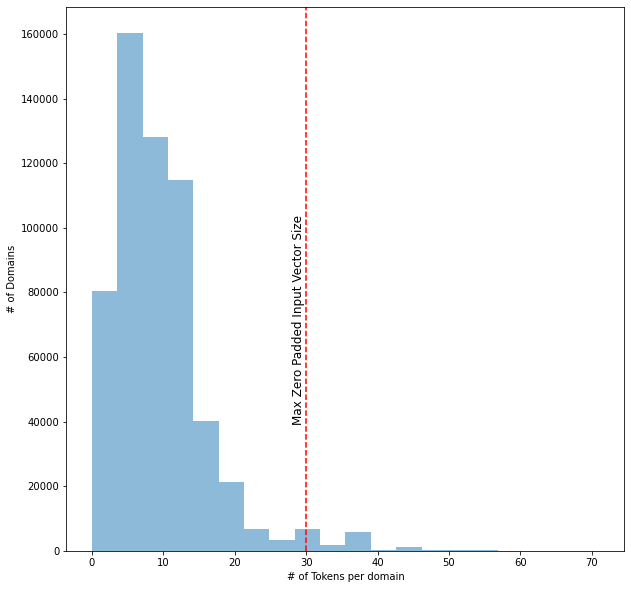

In [1275]:
#encoded_domains = list(map(lambda x: bpe.encode(x),df.domain.values))
#encoded_ct = [len(i) for i in encoded_domains]
print('% of data affected by 30 token maxmimum: ',np.round(100*np.sum(np.array(encoded_ct)>30)/len(encoded_ct),0))
plt.figure(figsize=(10,10))
plt.hist(encoded_ct,bins=20,alpha=0.5)
plt.ylabel('# of Domains')
plt.xlabel('# of Tokens per domain')
plt.axvline(30,ls='--',color='red')
plt.text(28,40000,'Max Zero Padded Input Vector Size',rotation=90,size=12)

[(396, 82), (588, 2)]


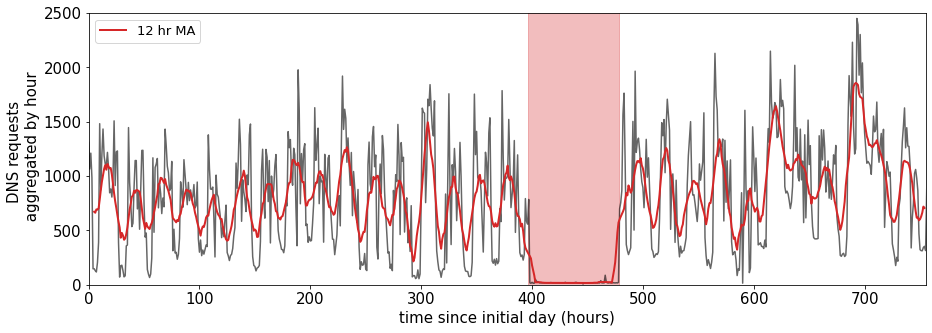

In [1157]:
from statsmodels.tsa.stattools import adfuller

def adjacent_fill(x):
    for i in range(int(len(x))):
        try:
            if sum(x[i:i+3]) == 3*x.max():
                x[i] = x.max()
            else:
                x[i] = 0.
        except:
            if sum(x[i:]) == len(x[i:])*x.max():
                x[i] = x.max()
            else:
                x[i] = 0.
    pairs = []
    contig = 0
    for j,xj in enumerate(x):
        if x[j] == x[np.min([j+1,len(x)-1])] and xj==0:
            contig += 1
            if contig == 1:
                init_j = j
        elif contig > 0:
            pairs.append((init_j,contig))
            contig = 0
    max_idx = np.argmax([i[1] for i in pairs])
    print(pairs)
    return x,pairs[max_idx]

by_hour = agg_df.copy()
by_day = agg_df.copy()
by_hour['timestamp'] = by_hour.timestamp // 3600
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(range(len(by_hour.groupby('timestamp').count().blocked)),by_hour.groupby('timestamp').count().blocked,
        color='black',alpha=0.6)
ax.plot(range(-6,len(by_hour.groupby('timestamp').count().blocked)-6),
        by_hour.groupby('timestamp').count().rolling(12).mean().blocked,lw=2,color='tab:red',label='12 hr MA')
plt.ylim(0,2500)
plt.xlim(0,755)
ax.set_ylabel('DNS requests \n aggregated by hour',size=15)
ax.set_xlabel('time since initial day (hours)',size=15)
x_mask,(bad_min,bad_max) = adjacent_fill(np.where(by_hour.groupby('timestamp').count().blocked < 50, 0, 2000))
ax.fill_betweenx([0,4000],bad_min,bad_min+bad_max,color='tab:red',alpha=0.3)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.legend(loc=2,prop={'size':13})
plt.savefig('time_series.png')

In [1470]:
def mask_idx(min_x,max_x,len_x):
    idx = range(len_x)
    idx_left = idx[:min_x]
    idx_right = idx[min_x+max_x:]
    return np.append(idx_left,idx_right)

cleaned = by_hour.groupby('timestamp').count().blocked.iloc[mask_idx(bad_min,bad_max,by_hour.timestamp.nunique())]
print('Time series mean',cleaned.mean().round(2),'Time series std',cleaned.std().round(2))

Time series mean 837.22 Time series std 487.05


Text(0.5, 1.0, 'Aggregate requests within a day')

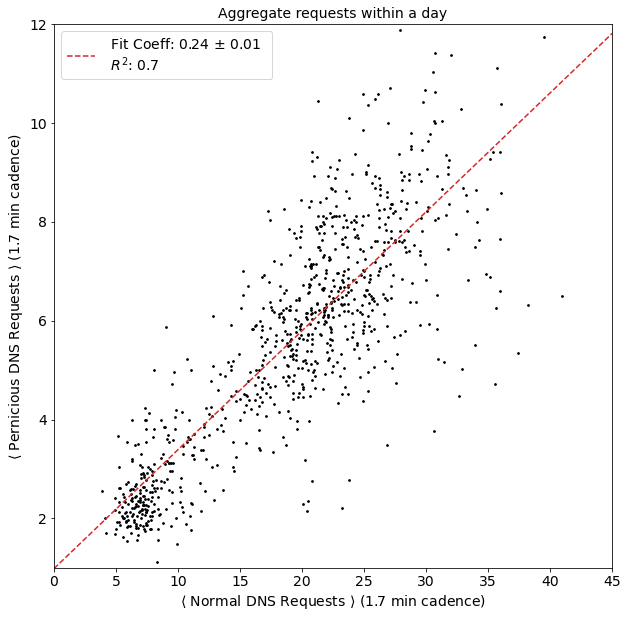

In [1471]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score
tod_counts = agg_df.groupby(['time_of_day','day']).sum().reset_index()#.not_blocked.values
tod_blocked_counts = agg_df.groupby(['time_of_day','day']).sum().reset_index()#.blocked.values
tod_counts = tod_counts.groupby('time_of_day').mean().not_blocked.values
tod_blocked_counts = tod_blocked_counts.groupby('time_of_day').mean().blocked.values

tod_counts = sm.add_constant(tod_counts.reshape(-1,1))

regression_model = sm.OLS(tod_blocked_counts.reshape(-1,1), tod_counts).fit()
#regression_model = LinearRegression().fit(tod_counts.reshape(-1,1),tod_blocked_counts.reshape(-1,1))

plt.figure(figsize=(10,10))
plt.scatter(tod_counts[:,1],tod_blocked_counts,s=3,color='black')
coeff = regression_model.params[1].round(2)
coeff_err = np.sqrt(regression_model.cov_params()[1][1]).round(2)
r2 = round(r2_score(tod_blocked_counts,regression_model.predict(tod_counts)),2)
plt.plot(np.linspace(0,50,1360),regression_model.predict(sm.add_constant(np.linspace(0,50,1360))),'--',
         label=' Fit Coeff: {0} $\pm$ {1}  \n $R^2$: {2}'.format(coeff,coeff_err,r2),color='tab:red')
plt.legend(fontsize=14)
plt.xlim(0,45)
plt.ylim(1,12)
plt.xlabel(r'$\langle$ Normal DNS Requests $\rangle$ (1.7 min cadence)',size=14)
plt.ylabel(r'$\langle$ Pernicious DNS Requests $\rangle$ (1.7 min cadence)',size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Aggregate requests within a day',size=14)
#plt.savefig('TimeOfDayRegression.png')

(array([-6., -4., -2.,  0.,  2.,  4.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

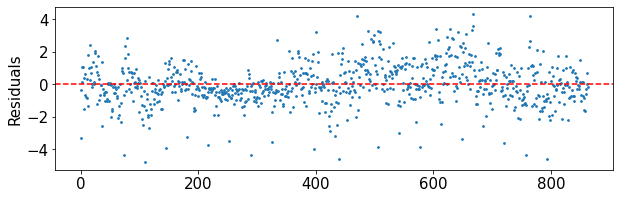

In [1472]:
"""
Look at the residuals of the fit.
"""
plt.figure(figsize=(10,3))
plt.scatter(range(len(tod_counts)),tod_blocked_counts-regression_model.predict(tod_counts),s=3)
plt.axhline(0,color='red',ls='--')
plt.ylabel('Residuals',size=15)
plt.xticks(size=15)
plt.yticks(size=15)

Text(0.5, 0, 'Domain Depth')

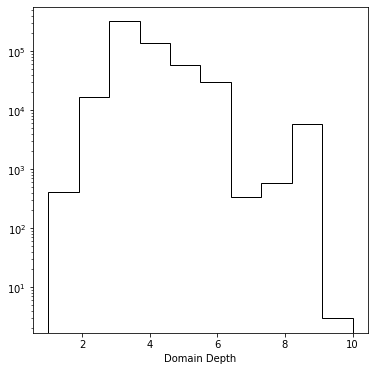

In [1265]:
plt.figure(figsize=(6,6))
plt.hist(df.domain.apply(lambda x: len(x.split('.'))).values,histtype='step',color='black')
plt.yscale('log')
plt.xlabel('Domain Depth')

In [1209]:
"""
Notes:
Run auto/cross correlations to pick out periodicities

""" 




'\nNotes:\nRun auto/cross correlations to pick out periodicities\n\n'

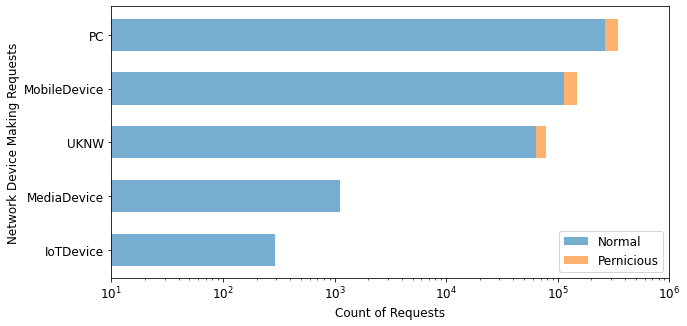

In [1133]:
"""
Look at the requests by type and by requesting device(client ip address).
"""
ip2name = {'192.168.0.112':'PC1','192.168.0.157':'IoTDevice1',
           '192.168.0.133':'IoTDevice3','192.168.0.192':'IoTDevice2',
          '192.168.0.161':'MobileDevice3','192.168.0.119':'PC2','192.168.0.129':'MobileDevice1',
          '192.168.0.121':'Raspberry Pi','192.168.0.155':'MediaDevice1','192.168.0.156':'PC3',
          '192.168.0.149':'MobileDevice2'}
#agg_df['client'] = agg_df.client.apply(lambda x: '192.168.0.120' if x=='127.0.0.1' else x)
agg_df['client_class'] = agg_df.client.apply(lambda x: ip2name.setdefault(x,'UKNWN')[:-1])
client_grp = agg_df.groupby('client_class').sum().reset_index()
total_sort = np.argsort(client_grp.blocked.values+client_grp.not_blocked.values)

plt.figure(figsize=(10,5))
plt.barh(np.arange(len(client_grp)),client_grp.not_blocked[total_sort],height=0.6,
         color='tab:blue',alpha=0.6,label='Normal')
plt.barh(np.arange(len(client_grp)),client_grp.blocked[total_sort],left=client_grp.not_blocked[total_sort],
         height=0.6,color='tab:orange',alpha=0.6,label='Pernicious')
plt.yticks(range(len(client_grp)),client_grp.client_class[total_sort],size=12)
plt.xticks(size=12)
#plt.text(10000,0.9,'{0}'.format(client_grp.not_blocked[total_sort].iloc[1]))
#plt.text(350,-0.1,'{0}'.format(client_grp.not_blocked[total_sort].iloc[0]),size=12)
plt.xscale('log')
plt.xlim(10**1,10**6)
plt.ylabel('Network Device Making Requests',size=12)
plt.xlabel('Count of Requests',size=12)
plt.legend(loc=0,prop={'size':12})
plt.savefig('NetworkDeviceAnalysis.png')

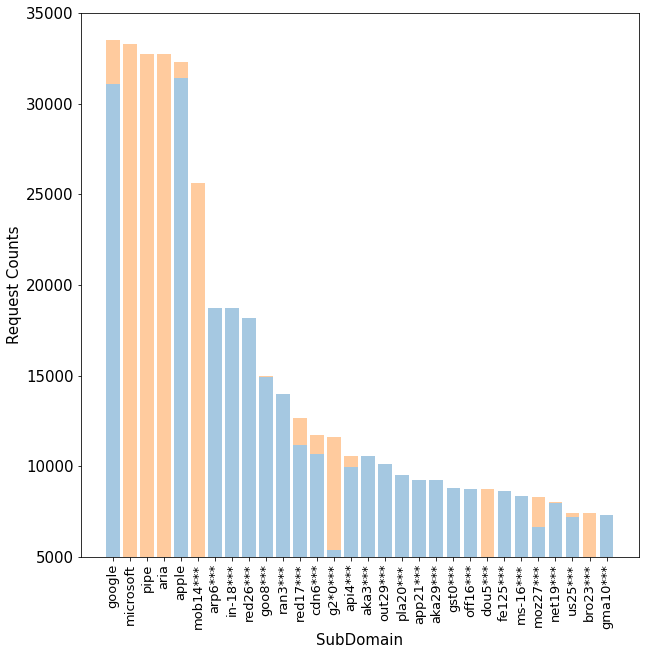

In [1507]:
"""
Look at domain subdomain frequencies.
Note: Look into how to prune random alphanumerics.

"""
from tqdm import tqdm
def word_freq(x):
    uni_x = np.unique(x)
    x = np.array(x)
    freqs_domains = [(np.sum(x==i),i) for i in tqdm(uni_x) if i not in ['com','net','org','edu','www']]
    freqs = [i[0] for i in freqs_domains]
    uni_x_ = [i[1] for i in freqs_domains]
    return freqs,uni_x_

def checknum(x):
    return any(i.isdigit() for i in x)

def redact(x):
    rnd_num = np.random.randint(30)
    return x[:3]+str(rnd_num)+'***'

def freqbyblocked(dframe,word,blocked=True):
    if blocked:
        freq = dframe.loc[dframe.domain.apply(lambda x: word in x.split('.'))].blocked.sum()
    else:
        freq = dframe.loc[dframe.domain.apply(lambda x: word in x.split('.'))].not_blocked.sum()
    return freq

#raw_subdomains = np.concatenate(df.domain.apply(lambda x: x.split('.')).values)
#raw_subdomains_nonum = [i for i in tqdm(raw_subdomains) if not checknum(i)]
#wfreq,word = word_freq(raw_subdomains_nonum)
#wsort = np.argsort(wfreq)[::-1]
#word_sorted = np.array(word)[wsort][:30]

#blocked_freq = list(map(lambda x: freqbyblocked(df,x),word_sorted))
#nonblocked_freq = list(map(lambda x: freqbyblocked(df,x,blocked=False),word_sorted))

wfreq_sorted = np.array(wfreq)[wsort][:30]
word_sorted = np.array([redact(word) if i > 4 else word for i,word in enumerate(word_sorted)])

plt.figure(figsize=(10,10))
#plt.bar(word_sorted,wfreq_sorted,alpha=0.4)

plt.bar(word_sorted,nonblocked_freq,alpha=0.4)
plt.bar(word_sorted,blocked_freq,alpha=0.4,bottom=nonblocked_freq)
plt.xticks(rotation=90,size=13)
plt.yticks(size=15)
plt.xlabel('SubDomain',size=15)
plt.ylabel('Request Counts',size=15)
plt.ylim(5000,35000)
plt.savefig('DomainDist.png')
#plt.yscale('log')

In [1504]:
df.loc[df.domain.apply(lambda x: 'ad' in x and 'google.' in x)]
#df.loc[df.domain.apply(lambda x: 'mobile' in x)].blocked.sum()
#blocked_freq = list(map(lambda x: freqbyblocked(df,x,blocked=True),word_sorted))
#blocked_freq

,id,timestamp,type,status,domain,client,forward,additional_info,blocked,not_blocked
28,13122,1600736407,1,1,adservice.google.com,192.168.0.147,None,None,1,0
169,13263,1600736826,1,1,adservice.google.com,192.168.0.147,None,None,1,0
254,13348,1600737040,1,1,adservice.google.com,192.168.0.147,None,None,1,0
342,13436,1600737210,1,2,gstaticadssl.l.google.com,192.168.0.147,8.8.4.4,None,0,1
364,13458,1600737247,1,1,adservice.google.com,192.168.0.147,None,None,1,0
...,...,...,...,...,...,...,...,...,...,...
570978,608688,1603555575,1,1,adservice.google.com,192.168.0.161,None,None,1,0
571054,608764,1603555745,1,1,adservice.google.com,192.168.0.161,None,None,1,0
571126,608836,1603555835,1,1,adservice.google.com,192.168.0.161,None,None,1,0
571168,608878,1603555920,1,1,adservice.google.com,192.168.0.161,None,None,1,0


(0.0, 3.0)

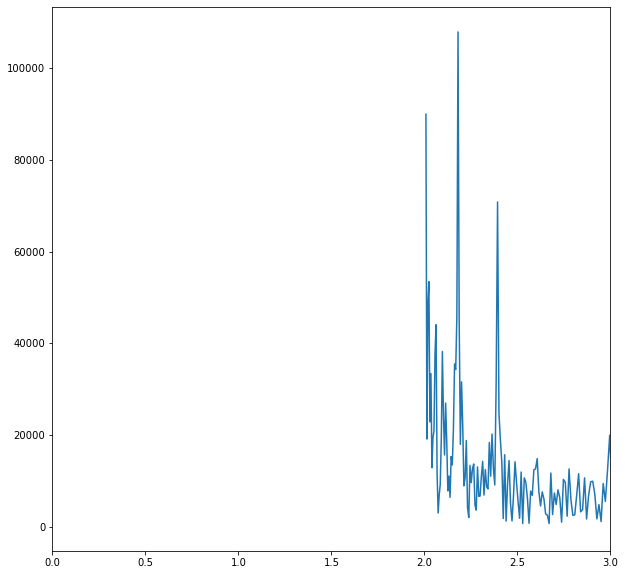

In [1264]:
fft_req_ct = np.abs(np.fft.fft(medfilt(by_hour.groupby('timestamp').count().blocked)))[::-1]

freqs = np.fft.fftfreq(len(fft_req_ct),d=1)[:int(len(fft_req_ct)/2)][1:]
time = np.nan_to_num(1./freqs)[::-1]

plt.figure(figsize=(10,10))
plt.plot(time,fft_req_ct[:int(len(fft_req_ct)/2)][1:])
#plt.yscale('log')
plt.xlim(0,3)


In [1338]:
raw_subdomains_nonum

['mobile',
 'pipe',
 'aria',
 'microsoft',
 'com',
 'mobile',
 'pipe',
 'aria',
 'microsoft',
 'com',
 'telemetry',
 'dropbox',
 'com',
 'login',
 'live',
 'com',
 'edge',
 'skype',
 'com',
 'ocsp',
 'apple',
 'com',
 'config',
 'edge',
 'skype',
 'com',
 'prod',
 'registrar',
 'skype',
 'com',
 'api',
 'asm',
 'skype',
 'com',
 'ss-prod-ue1-notif-59',
 'aws',
 'adobess',
 'com',
 'caldav',
 'fe',
 'apple-dns',
 'net',
 'zpns',
 'zoom',
 'us',
 'nexus',
 'officeapps',
 'live',
 'com',
 'officeclient',
 'microsoft',
 'com',
 'ocos-office365-s2s-msedge-net',
 'e-0009',
 'e-msedge',
 'net',
 'client-office365-tas',
 'msedge',
 'net',
 'maps',
 'gstatic',
 'com',
 'nexusrules',
 'officeapps',
 'live',
 'com',
 'nexus',
 'officeapps',
 'live',
 'com',
 'browser',
 'pipe',
 'aria',
 'microsoft',
 'com',
 'in-addr',
 'arpa',
 'in-addr',
 'arpa',
 'in-addr',
 'arpa',
 'in-addr',
 'arpa',
 'in-addr',
 'arpa',
 'in-addr',
 'arpa',
 'shavar',
 'services',
 'mozilla',
 'com',
 'plus',
 'l',
 'goog